# Concrete Crack Detection with PyTorch

## Table of contents

## Data Installation and Information

**Download the data**

In case you can't find it on the internet. I will provide a code here, which can be runned to install the dataset automatically into your local file system (this code support for linux system).

In [ ]:
!pip install kaggle
!kaggle datasets download -d arnavr10880/concrete-crack-images-for-classification --force

In [ ]:
import zipfile

with zipfile.ZipFile('concrete-crack-images-for-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

**About the Data**
- The dataset contains concrete images having cracks. The data is collected from various METU Campus Buildings.
- The dataset is divided into two as negative and positive crack images for image classification. 
- Each class has 20000images with a total of 40000 images with 227 x 227 pixels with RGB channels. 
- The dataset is generated from 458 high-resolution images (4032x3024 pixel) with the method proposed by Zhang et al (2016). 
- High-resolution images have variance in terms of surface finish and illumination conditions. 
- No data augmentation in terms of random rotation or flipping is applied. 

Cite: Özgenel, Çağlar Fırat (2019), “Concrete Crack Images for Classification”, Mendeley Data, V2, doi: 10.17632/5y9wdsg2zt.2

For more detail, you can check at this [link](https://data.mendeley.com/datasets/5y9wdsg2zt/2)

## Import Libraries and Auxiliary Functions

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)

## Build Dataset

Here, we'll set up a dataset class inherit from `Dataset` object of PyTorch, we'll devide the dataset into 2 part, one for training and the other for validation. The train set will include 30000 samples, and the validation set will include 10000 samples, the labels will be assigned accordingly.

In [2]:
class Concrete_Dataset(Dataset):
    def __init__(self, transform=None, train=True):
        directory = "./data"
        positive = "Positive"
        negative = 'Negative'

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith(".jpg")]
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith(".jpg")]
        number_of_samples = len(positive_files) + len(negative_files)
        self.all_files = [None] * number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files 

        self.transform = transform
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        
        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)     

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        image = Image.open(self.all_files[idx])
        y = self.Y[idx]
                  
        if self.transform:
            image = self.transform(image)

        return image, y

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

train_dataset = Concrete_Dataset(transform=transform, train=True)
validation_dataset = Concrete_Dataset(transform=transform, train=False)

In [5]:
train_dataset[0][0].shape

torch.Size([3, 227, 227])

## Build Model

In [6]:
# create a pretrained ResNet18
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

/opt/homebrew/Caskroom/miniconda/base/envs/ai-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ai-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 

Then, we'll replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.

In [7]:
number_of_classes = 2

model.fc = nn.Linear(512, number_of_classes)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train Model

Here we'll use the `CrossEntropyLoss` for criterion, `Adam optimizer` with `learning_rate = 0.001`.
And create `dataloader` for both training and validation with `batch_size = 100`

In [8]:
# create the loss function
criterion = nn.CrossEntropyLoss()

# create an optimizer for the model
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001)

# data loader for batch processing in training and validation
train_loader = DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100)

Now, we'll combine them all and start to train the model, the `loss` and `accuracy` will be recorded for further insights.

In [9]:
n_epochs = 1
loss_list = []
accuracy_list = []
N_test = len(validation_dataset)
N_train = len(train_dataset)

Loss = 0

for epoch in range(n_epochs):
    for x, y in train_loader:
        model.train() 
        # clear gradient 
        optimizer.zero_grad()
        # make a prediction 
        z = model(x)
        # calculate loss 
        loss = criterion(z, y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)

    correct = 0
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        # make a prediction 
        z = model(x_test)
        # find max 
        _, yhat = torch.max(z.data, 1)
       
        # calculate misclassified  samples in mini-batch 
        correct += (yhat == y_test).sum().item()  
        
    accuracy = correct / N_test
    accuracy_list.append(accuracy)

## Evaluation

In [10]:
print(f'Model accuracy: {accuracy}')

Model accuracy: 0.9924


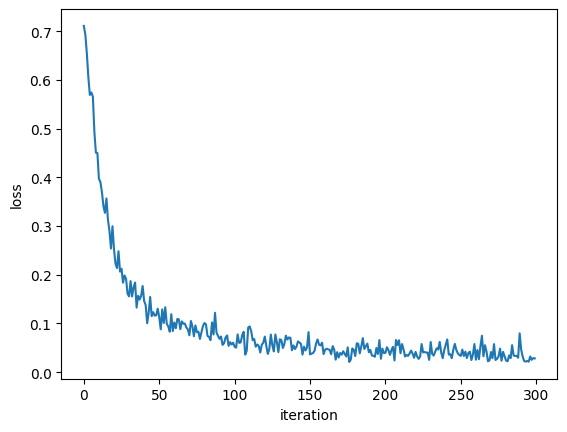

In [11]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

The accuracy obtained is very high, around 99%. 

The loss line is not really smooth, but it generally decrease, rappidly in the first 50 iterations, slower in the rest iteration.

We'll check out some misclassified samples

In [12]:
misclassified_count = 0
validation_single_loader = DataLoader(dataset=validation_dataset, batch_size=1)
i = 0

for x_test, y_test in validation_single_loader:
    i += 1
    if misclassified_count == 4:
        break
        
    model.eval()
    z = model(x_test)
    _, yhat = torch.max(z.data, 1)

    misclassified = (yhat != y_test).nonzero()
    if len(misclassified) > 0:
        misclassified_count += 1
        print(f'sample {i} - predicted value: {yhat} - actual value: {y_test}')

sample 223 - predicted value: tensor([0]) - actual value: tensor([1])
sample 271 - predicted value: tensor([0]) - actual value: tensor([1])
sample 567 - predicted value: tensor([0]) - actual value: tensor([1])
sample 871 - predicted value: tensor([0]) - actual value: tensor([1])
